# GPU Memory Utilization Dashboard

This notebook provides a local equivalent to Google Colab's GPU memory dashboard. It monitors NVIDIA GPU memory usage, utilization, and temperature in real-time.

Based on the `nvidia-ml-py` library.

In [1]:
import pynvml
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time
import threading
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch

# Initialize NVIDIA management library
pynvml.nvmlInit()

# Get number of GPUs
device_count = pynvml.nvmlDeviceGetCount()
print(f"Found {device_count} GPU(s)")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"PyTorch CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA not available in PyTorch")

Found 1 GPU(s)
PyTorch CUDA devices: 1
  Device 0: NVIDIA GeForce RTX 5070


In [2]:
def get_gpu_info(device_id=0):
    """Get GPU memory and utilization information"""
    try:
        handle = pynvml.nvmlDeviceGetHandleByIndex(device_id)
        
        # Memory info
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        
        # Utilization
        util_info = pynvml.nvmlDeviceGetUtilizationRates(handle)
        
        # Temperature
        try:
            temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
        except:
            temp = None
        
        # Device name
        name = pynvml.nvmlDeviceGetName(handle)
        
        return {
            'name': name.decode('utf-8') if isinstance(name, bytes) else name,
            'memory_used': mem_info.used / 1024**2,  # MB
            'memory_total': mem_info.total / 1024**2,  # MB
            'memory_free': mem_info.free / 1024**2,    # MB
            'memory_percent': (mem_info.used / mem_info.total) * 100,
            'gpu_utilization': util_info.gpu,
            'memory_utilization': util_info.memory,
            'temperature': temp,
            'timestamp': time.time()
        }
    except Exception as e:
        return {'error': str(e)}

# Test the function
gpu_info = get_gpu_info()
if 'error' not in gpu_info:
    print(f"GPU: {gpu_info['name']}")
    print(f"Memory: {gpu_info['memory_used']:.1f}MB / {gpu_info['memory_total']:.1f}MB ({gpu_info['memory_percent']:.1f}%)")
    print(f"GPU Utilization: {gpu_info['gpu_utilization']}%")
    if gpu_info['temperature']:
        print(f"Temperature: {gpu_info['temperature']}°C")
else:
    print(f"Error: {gpu_info['error']}")

GPU: NVIDIA GeForce RTX 5070
Memory: 472.0MB / 12227.0MB (3.9%)
GPU Utilization: 0%
Temperature: 40°C


In [3]:
class GPUMonitor:
    """GPU monitoring class with data collection and plotting"""
    
    def __init__(self, device_id=0, max_history=100):
        self.device_id = device_id
        self.max_history = max_history
        self.is_monitoring = False
        self.monitor_thread = None
        
        # Data storage
        self.timestamps = []
        self.memory_used = []
        self.memory_percent = []
        self.gpu_utilization = []
        self.temperatures = []
    
    def start_monitoring(self, interval=1.0):
        """Start background monitoring"""
        if self.is_monitoring:
            print("Already monitoring")
            return
        
        self.is_monitoring = True
        self.monitor_thread = threading.Thread(target=self._monitor_loop, args=(interval,))
        self.monitor_thread.daemon = True
        self.monitor_thread.start()
        print("GPU monitoring started")
    
    def stop_monitoring(self):
        """Stop background monitoring"""
        self.is_monitoring = False
        if self.monitor_thread:
            self.monitor_thread.join(timeout=2)
        print("GPU monitoring stopped")
    
    def _monitor_loop(self, interval):
        """Background monitoring loop"""
        while self.is_monitoring:
            info = get_gpu_info(self.device_id)
            
            if 'error' not in info:
                self.timestamps.append(info['timestamp'])
                self.memory_used.append(info['memory_used'])
                self.memory_percent.append(info['memory_percent'])
                self.gpu_utilization.append(info['gpu_utilization'])
                
                if info['temperature'] is not None:
                    self.temperatures.append(info['temperature'])
                
                # Limit history
                if len(self.timestamps) > self.max_history:
                    self.timestamps.pop(0)
                    self.memory_used.pop(0)
                    self.memory_percent.pop(0)
                    self.gpu_utilization.pop(0)
                    if self.temperatures:
                        self.temperatures.pop(0)
            
            time.sleep(interval)
    
    def get_current_stats(self):
        """Get current GPU statistics"""
        info = get_gpu_info(self.device_id)
        if 'error' not in info:
            return info
        return None
    
    def get_memory_usage_mb(self):
        """Get current memory usage in MB"""
        stats = self.get_current_stats()
        if stats:
            return stats['memory_used'], stats['memory_total']
        return 0, 0
    
    def get_memory_usage_percent(self):
        """Get current memory usage percentage"""
        stats = self.get_current_stats()
        if stats:
            return stats['memory_percent']
        return 0

# Create monitor instance
monitor = GPUMonitor()

In [4]:
import time
import threading
import ipywidgets as widgets
from IPython.display import display

def create_dashboard():
    """Create an interactive GPU dashboard with widgets"""

    # Create widgets
    status_text = widgets.Textarea(
        value='',
        placeholder='GPU status will appear here',
        description='GPU Status:',
        disabled=True,
        layout=widgets.Layout(width='100%', height='120px')
    )

    memory_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=100,
        description='Memory:',
        bar_style='info',
        style={'bar_color': '#1f77b4'},
        layout=widgets.Layout(width='100%')
    )

    gpu_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=100,
        description='GPU Util:',
        bar_style='success',
        style={'bar_color': '#ff7f0e'},
        layout=widgets.Layout(width='100%')
    )

    temp_display = widgets.Label(value='Temperature: N/A')

    start_button = widgets.Button(description='Start Monitoring', button_style='info')
    stop_button = widgets.Button(description='Stop Monitoring', disabled=True)

    # Thread control
    stop_event = threading.Event()
    thread_holder = {'thread': None}

    def update_dashboard():
        """Update dashboard with current GPU info"""
        # Reflect monitor state in buttons
        if getattr(monitor, 'is_monitoring', False):
            start_button.disabled = True
            stop_button.disabled = False
        else:
            start_button.disabled = False
            stop_button.disabled = True

        try:
            stats = monitor.get_current_stats()
        except Exception as e:
            status_text.value = f"Unable to get GPU information: {e!r}"
            return

        if stats:
            used, total = stats['memory_used'], stats['memory_total']
            status_text.value = (
                f"GPU: {stats['name']}\n"
                f"Memory: {used:.1f}MB / {total:.1f}MB\n"
                f"GPU Util: {stats['gpu_utilization']}%"
            )

            memory_progress.value = stats['memory_percent']
            memory_progress.description = f"Memory: {stats['memory_percent']:.1f}%"

            gpu_progress.value = stats['gpu_utilization']
            gpu_progress.description = f"GPU Util: {stats['gpu_utilization']:.0f}%"

            if stats.get('temperature') is not None:
                temp_display.value = f"Temperature: {stats['temperature']}°C"
            else:
                temp_display.value = 'Temperature: N/A'
        else:
            status_text.value = "Unable to get GPU information"

    # Background loop (stoppable)
    def periodic_loop():
        while not stop_event.is_set():
            update_dashboard()
            time.sleep(2)  # Update every 2 seconds

    # Button callbacks
    def on_start_clicked(_):
        stop_event.clear()
        try:
            monitor.start_monitoring(interval=1.0)
        except Exception:
            # If monitor handles its own state, ignore
            pass
        # Start the thread only if it's not already running
        t = thread_holder.get('thread')
        if not t or not t.is_alive():
            t = threading.Thread(target=periodic_loop, daemon=True)
            thread_holder['thread'] = t
            t.start()
        update_dashboard()

    def on_stop_clicked(_):
        try:
            monitor.stop_monitoring()
        except Exception:
            pass
        stop_event.set()
        update_dashboard()

    start_button.on_click(on_start_clicked)
    stop_button.on_click(on_stop_clicked)

    # Initial update (no loop yet)
    update_dashboard()

    # Display widgets
    controls = widgets.HBox([start_button, stop_button])
    progress_bars = widgets.VBox([memory_progress, gpu_progress])

    return widgets.VBox([
        status_text,
        progress_bars,
        temp_display,
        controls
    ])

# Create and display the dashboard
dashboard = create_dashboard()
display(dashboard)

Run the following code to start real-time plotting:
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

(First start monitoring with the widget dashboard above)


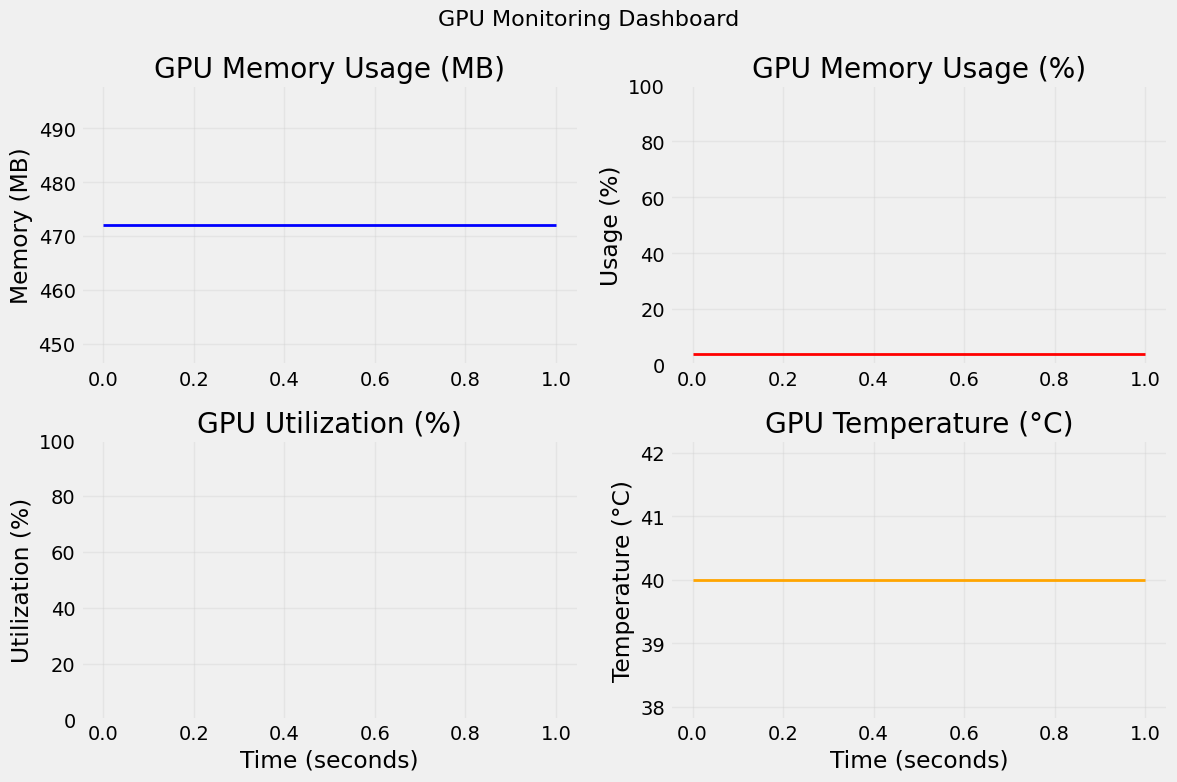

In [5]:
# Matplotlib-based real-time plotting

style.use('fivethirtyeight')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('GPU Monitoring Dashboard', fontsize=16)

def animate(i):
    """Animation function for real-time plotting"""
    if not monitor.timestamps:
        return
    
    # Convert timestamps to relative time
    times = [t - monitor.timestamps[0] for t in monitor.timestamps]
    
    # Clear axes
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    
    # Memory usage over time
    ax1.plot(times, monitor.memory_used, 'b-', linewidth=2)
    ax1.set_title('GPU Memory Usage (MB)')
    ax1.set_ylabel('Memory (MB)')
    ax1.grid(True, alpha=0.3)
    
    # Memory percentage
    ax2.plot(times, monitor.memory_percent, 'r-', linewidth=2)
    ax2.set_title('GPU Memory Usage (%)')
    ax2.set_ylabel('Usage (%)')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # GPU utilization
    ax3.plot(times, monitor.gpu_utilization, 'g-', linewidth=2)
    ax3.set_title('GPU Utilization (%)')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Utilization (%)')
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3)
    
    # Temperature (if available)
    if monitor.temperatures and len(monitor.temperatures) == len(times):
        ax4.plot(times, monitor.temperatures, 'orange', linewidth=2)
        ax4.set_title('GPU Temperature (°C)')
        ax4.set_xlabel('Time (seconds)')
        ax4.set_ylabel('Temperature (°C)')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Temperature\ndata not available', 
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('GPU Temperature (°C)')

# Note: Animation would run continuously - use with caution in notebooks
# To use: ani = animation.FuncAnimation(fig, animate, interval=1000)
# plt.show()

print("Run the following code to start real-time plotting:")
print("ani = animation.FuncAnimation(fig, animate, interval=1000)")
print("plt.show()")
print("\n(First start monitoring with the widget dashboard above)")

# Display current static plot (run animate once to populate)
animate(0)
plt.tight_layout()
plt.show()

In [ ]:
# Simple GPU allocation test for demonstration

def test_gpu_allocation():
    """Allocate some GPU memory to see the monitoring in action"""
    if not torch.cuda.is_available():
        print("CUDA not available - cannot test GPU allocation")
        return
    
    print("Allocating GPU tensors to demonstrate monitoring...")
    
    # Allocate increasing amounts of memory
    tensors = []
    sizes = [100, 500, 1000, 2000]  # MB approximately
    
    for size in sizes:
        # Create tensor that uses roughly 'size' MB
        tensor_size = int(size * 1024 * 1024 / 4)  # float32 = 4 bytes
        tensor = torch.randn(tensor_size, device='cuda')
        tensors.append(tensor)
        
        # Show current memory usage
        info = get_gpu_info()
        if 'error' not in info:
            print(f"Allocated ~{size}MB: Memory usage {info['memory_used']:.1f}MB ({info['memory_percent']:.1f}%)")
        
        time.sleep(0.5)  # Brief pause to see the change
    
    print("Clearing tensors...")
    del tensors
    torch.cuda.empty_cache()
    
    info = get_gpu_info()
    if 'error' not in info:
        print(f"After cleanup: Memory usage {info['memory_used']:.1f}MB ({info['memory_percent']:.1f}%)")

# Uncomment to test:
# test_gpu_allocation()

In [6]:
# Cleanup
monitor.stop_monitoring()
pynvml.nvmlShutdown()

print("GPU monitoring cleanup completed")

GPU monitoring stopped
GPU monitoring cleanup completed
